Train 60% / Test 40% - RMSE: 1.0641
Output saved to: /Users/aryanpatelkolagani/Documents/CS504/Assignmnets/Final_Project/Output_Files/CF_Output_Files/test_ratings_predictions_40_cf.csv
Train 70% / Test 30% - RMSE: 1.0641
Output saved to: /Users/aryanpatelkolagani/Documents/CS504/Assignmnets/Final_Project/Output_Files/CF_Output_Files/test_ratings_predictions_30_cf.csv
Train 80% / Test 20% - RMSE: 1.0655
Output saved to: /Users/aryanpatelkolagani/Documents/CS504/Assignmnets/Final_Project/Output_Files/CF_Output_Files/test_ratings_predictions_20_cf.csv
Train 90% / Test 10% - RMSE: 1.0659
Output saved to: /Users/aryanpatelkolagani/Documents/CS504/Assignmnets/Final_Project/Output_Files/CF_Output_Files/test_ratings_predictions_10_cf.csv


IntText(value=0, description='User ID:')

IntText(value=0, description='Movie ID:')

Button(description='Predict Rating', style=ButtonStyle())

Output()

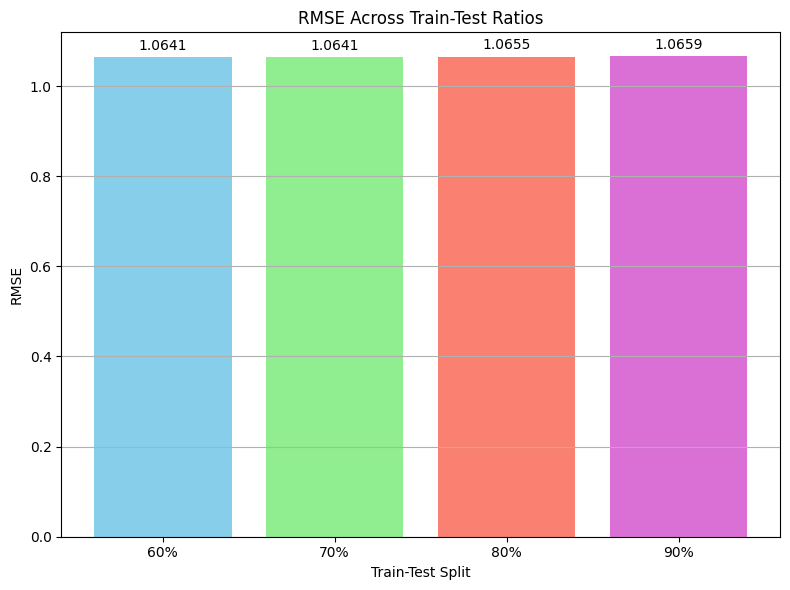

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt

# Load movie and rating datasets
def fetch_datasets():
    movies = pd.read_csv('/Users/aryanpatelkolagani/Downloads/movies.csv')
    ratings = pd.read_csv('/Users/aryanpatelkolagani/Downloads/ratings.csv')
    return movies, ratings

# Compute Pearson correlation-based similarity matrix
def compute_similarity_matrix(centered_data):
    std_devs = centered_data.std()
    variable_columns = std_devs[std_devs > 0].index
    filtered_data = centered_data[variable_columns]

    similarity = np.corrcoef(filtered_data.T)
    similarity = np.nan_to_num(similarity)
    return similarity, variable_columns

# Generate predicted ratings using collaborative filtering
def generate_predictions(similarity, centered_data, variable_columns):
    filtered_data = centered_data[variable_columns]

    weighted_scores = similarity.dot(filtered_data.fillna(0).T)
    weight_sums = np.abs(similarity).sum(axis=1, keepdims=True)
    weight_sums[weight_sums == 0] = np.nan
    weight_sums = np.nan_to_num(weight_sums, nan=1)

    predicted_scores = weighted_scores / weight_sums
    predicted_df = pd.DataFrame(predicted_scores.T, index=centered_data.index, columns=variable_columns)
    return predicted_df

# Compute RMSE between actual and predicted values
def evaluate_rmse(actual, predicted):
    valid_mask = ~np.isnan(actual) & ~np.isnan(predicted)
    rmse = sqrt(mean_squared_error(actual[valid_mask], predicted[valid_mask]))
    return rmse

# Core function to run collaborative filtering over multiple data splits
def run_collab_filtering(split_fractions):
    movies, ratings = fetch_datasets()
    rmse_scores = []

    for train_frac in split_fractions:
        test_frac = 1 - train_frac
        train_data, test_data = train_test_split(ratings, test_size=test_frac, random_state=42)

        pivot_train = train_data.pivot(index='userId', columns='movieId', values='rating')
        centered_train = pivot_train - pivot_train.mean()
        filled_centered = centered_train.fillna(0)

        similarity_matrix, valid_columns = compute_similarity_matrix(filled_centered)
        prediction_matrix = generate_predictions(similarity_matrix, filled_centered, valid_columns)
        overall_mean = pivot_train.mean().mean()
        prediction_matrix += overall_mean

        test_df_copy = test_data[['userId', 'movieId', 'rating']].copy()
        test_df_copy['predicted_rating'] = prediction_matrix.stack().reset_index(drop=True)
        test_df_copy['predicted_rating'] = test_df_copy['predicted_rating'].round(2)

        output_path = f'/Users/aryanpatelkolagani/Documents/CS504/Assignmnets/Final_Project/Output_Files/CF_Output_Files/test_ratings_predictions_{test_frac*100:.0f}_cf.csv'
        test_df_copy.to_csv(output_path, index=False)

        pivot_test = test_data.pivot(index='userId', columns='movieId', values='rating')
        test_masked = pivot_test.where(~pivot_test.isna(), np.nan)
        predictions_aligned = prediction_matrix.reindex_like(test_masked)

        current_rmse = evaluate_rmse(test_masked.values.flatten(), predictions_aligned.values.flatten())
        rmse_scores.append(current_rmse)

        print(f"Train {train_frac:.0%} / Test {test_frac:.0%} - RMSE: {current_rmse:.4f}")
        print(f"Output saved to: {output_path}")
    
    return rmse_scores

# List of training split ratios
split_fractions = [0.6, 0.7, 0.8, 0.9]
rmse_results = run_collab_filtering(split_fractions)

# Predict ratings for individual user and movie
def retrieve_prediction(user_id, movie_id):
    movies, ratings = fetch_datasets()

    if user_id not in ratings['userId'].unique() or movie_id not in ratings['movieId'].unique():
        return None, None

    training_data, _ = train_test_split(ratings, test_size=0.2, random_state=42)
    pivot_data = training_data.pivot(index='userId', columns='movieId', values='rating')
    centered = pivot_data - pivot_data.mean()
    filled = centered.fillna(0)

    sim_matrix, columns = compute_similarity_matrix(filled)
    predictions = generate_predictions(sim_matrix, filled, columns)
    predictions += pivot_data.mean().mean()

    predicted = predictions.loc[user_id, movie_id]
    movie_info = movies[movies['movieId'] == movie_id]
    return round(predicted, 2), movie_info

# Widgets for interactive user input
uid_widget = widgets.IntText(description="User ID:")
mid_widget = widgets.IntText(description="Movie ID:")
output_box = widgets.Output()

# Button click event to show prediction
def on_predict_click(btn):
    uid = uid_widget.value
    mid = mid_widget.value
    rating, info = retrieve_prediction(uid, mid)
    with output_box:
        output_box.clear_output()
        if rating is not None and info is not None:
            print(f"Predicted Rating: {rating}\nMovie Info:\n{info}")
        else:
            print("Invalid User ID or Movie ID.")

# Button widget setup
predict_btn = widgets.Button(description="Predict Rating")
predict_btn.on_click(on_predict_click)

# Display all widgets
display(uid_widget, mid_widget, predict_btn, output_box)

# Plot RMSE bar chart
plt.figure(figsize=(8, 6))
bar_colors = ['skyblue', 'lightgreen', 'salmon', 'orchid']
labels = [f"{int(r*100)}%" for r in split_fractions]

plt.bar(labels, rmse_results, color=bar_colors)
plt.title("RMSE Across Train-Test Ratios")
plt.xlabel("Train-Test Split")
plt.ylabel("RMSE")
plt.grid(axis='y')

# Annotate bars with RMSE values
for i, val in enumerate(rmse_results):
    plt.text(i, val + 0.01, f"{val:.4f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()
